# 2025 DL Lab7: Image Generation

**Your Answer:**    
Hi I'm 邱照元, 314834001.

## Overview
This assignment focuses on implementing a deep generative model to synthesize high-quality floral images using the **Oxford Flowers102 dataset**. 

The objective is to train the model to capture fine-grained features and complex textures inherent in the data distribution. 

To quantitatively measure the performance, the **Fréchet Inception Distance (FID)** is employed as the primary metric, assessing both the fidelity and diversity of the generated samples against the real training data.

## Unzip resized_flowers102.zip

This file contains the Flowers102 dataset cropped to a 64x64 resolution, intended for the final FID score calculation. 

It comprises a total of **8,189** images.

可以使用其他的模型，不只是 GAN

In [163]:
#%matplotlib inline
import random
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim 
import torch.utils.data
import torchvision.utils as vutils
import torch
import numpy as np
import os

# 設定環境變數，強制讓 CuBLAS 運算具備確定性
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 0
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Random Seed:  0


In [ ]:
# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 7.5e-4

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of times to update the critic before updating the generator
n_critic = 8

# Weight clipping range
clip_value = 0.1

In [165]:
from torch.utils.data import ConcatDataset

##########################################################################
# TODO: Define the data transformation pipeline.                         #
# You need to implement a Compose pipeline that includes:                #
# 1. Resizing images to the target size(64*64).                          #
# 2. Applying data augmentation techniques to increase dataset diversity #
# 3. Converting images to Tensor.                                        #
# 4. Normalizing the pixel values to the range [-1, 1].                  #
##########################################################################

transform = transforms.Compose([
    # Your Code Here
    T.RandomResizedCrop(size=image_size, ratio=(1.0, 1.0), scale=(0.81, 1.0)),
    # T.RandAugment(),
    T.ColorJitter(
        brightness = 0.05,
        contrast = 0.05,
        saturation = (0.8,1.3),
        hue = 0.05
    ),
    T.RandomHorizontalFlip(0.5),
    
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)
testset = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
validdataset = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
dataset = ConcatDataset([trainset, testset, validdataset])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print("訓練集樣本數量:", len(dataset))

訓練集樣本數量: 8189


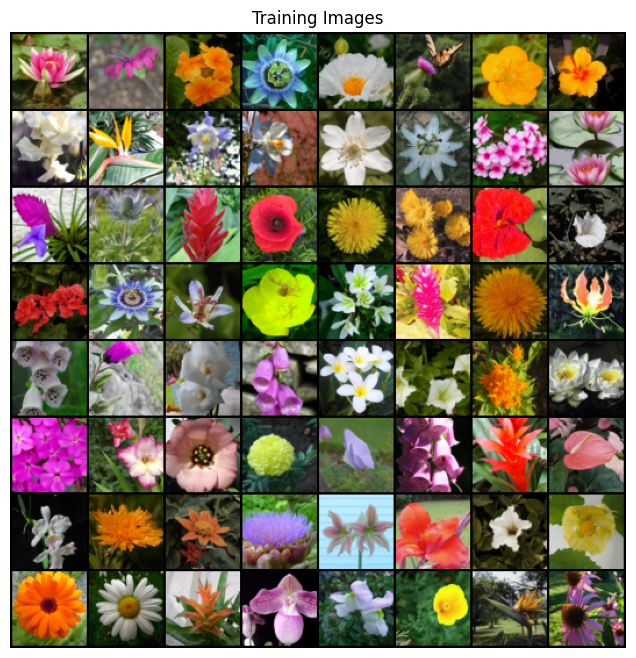

In [167]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Initialize parameters of Generator and Discriminator
This step for initializing the parameters of the generator and discriminator.
And define the structure of the dcGAN.

In [168]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [169]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z (latent vector), going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            #############################################################################
            # TODO: Implement the Upsampling Blocks.                                    #
            # You need to progressively increase the spatial size of the feature maps   #
            # while decreasing the number of channels.                                  #
            # The goal is to reach a feature map size compatible with the final output. #
            #############################################################################
            # state size. (ngf*8) x 4 x 4 -> (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8 -> (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16 -> (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #############################################################################

            # Final output layer
            # State size: (ngf) x 32 x 32 -> (nc) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [170]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            #############################################################################
            # TODO: Implement the Downsampling Blocks.                                  #
            # You need to progressively decrease the spatial size of the feature maps   #
            # while increasing the number of channels to extract features.              #
            #############################################################################
            # State size: (ndf) x 32 x 32
            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.InstanceNorm2d(ndf * 2, affine=True), 
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*2) x 16 x 16
            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.InstanceNorm2d(ndf * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*4) x 8 x 8
            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.InstanceNorm2d(ndf * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            #############################################################################

            # Final classification layer
            # State size: (ndf*8) x 4 x 4 -> 1
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [171]:
# Create the generator
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)


# Create the Discriminator
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [172]:
# Fixed noise vector for observing generator's progression
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Optimizers use RMSProp, not Adam
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [173]:
G_PATH = './model_weight/Gen.pth'
D_PATH = './model_weight/Dis.pth'

netG.load_state_dict(torch.load(G_PATH))
netD.load_state_dict(torch.load(D_PATH))

<All keys matched successfully>

## Training Step

In [176]:
import torch.autograd as autograd

def compute_gradient_penalty(netD, real_samples, fake_samples, device=torch.device("cuda:0")):
    """
    計算 WGAN-GP 的 Gradient Penalty
    """
    # 隨機權重 alpha: shape 要擴充成跟圖片一樣 (Batch, C, H, W)
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    
    # 1. 產生插值圖片 (interpolates)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # 2. 把插值圖丟進判別器
    d_interpolates = netD(interpolates)
    
    # 3. 計算梯度 (Gradients)
    fake = torch.ones(d_interpolates.size(), device=device, requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # 4. 計算梯度的 L2 Norm
    # 將 (Batch, C, H, W) 展平成 (Batch, Feature_Length)
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

def update_critic(netD, netG, optimizerD, real_data, noise, clip_value=0.01):
    """
    更新 Critic (Discriminator)
    Loss Formula: minimize -(E[D(x)] - E[D(G(z))])
    也就是: minimize -mean(D(real)) + mean(D(fake))
    """
    netD.zero_grad()
    
    # 1. Real Data Loss (Maximize D(x) -> Minimize -D(x))
    output_real = netD(real_data).view(-1)
    loss_real = -torch.mean(output_real)
    loss_real.backward()
    
    # 2. Fake Data Loss (Minimize D(G(z)))
    fake_data = netG(noise)
    # 注意: 這裡要 detach，避免梯度傳回 Generator
    output_fake = netD(fake_data.detach()).view(-1)
    loss_fake = torch.mean(output_fake)
    loss_fake.backward()
    
    # Update weights
    optimizerD.step()
    
    # 3. Weight Clipping (WGAN 獨有特徵)
    # 強制權重在 [-c, c] 之間以滿足 Lipschitz constraint
    for p in netD.parameters():
        p.data.clamp_(-clip_value, clip_value)
        
    # 回傳總 Loss 供紀錄
    return loss_real + loss_fake

# 初始化參數
lambda_gp = 10

def update_critic_gp(netD, netG, optimizerD, real_data, noise, clip_value=0.1):
    netD.zero_grad()
    
    # 1. Real Data Loss
    output_real = netD(real_data).view(-1)
    loss_real = -torch.mean(output_real)
    
    # 2. Fake Data Loss
    fake_data = netG(noise)
    output_fake = netD(fake_data.detach()).view(-1)
    loss_fake = torch.mean(output_fake)
    
    # 3. 計算 Gradient Penalty (WGAN-GP 新增部分)
    gradient_penalty = compute_gradient_penalty(netD, real_data, fake_data.detach())
    
    # 4. 總 Loss = Wasserstein Distance + Lambda * GP
    # 注意: 這裡我們是要 Minimize Loss，所以符號方向一致
    loss_D = loss_real + loss_fake + (lambda_gp * gradient_penalty)
    
    loss_D.backward()
    optimizerD.step()
    
    # # 3. Weight Clipping (WGAN 獨有特徵)
    # # 強制權重在 [-c, c] 之間以滿足 Lipschitz constraint
    # for p in netD.parameters():
    #     p.data.clamp_(-clip_value, clip_value)
    
    return loss_D

def update_generator(netD, netG, optimizerG, noise):
    """
    更新 Generator
    Loss Formula: maximize D(G(z)) -> minimize -D(G(z))
    """
    netG.zero_grad()
    
    fake_data = netG(noise)
    # Generator 更新時，需要梯度穿過 D，所以不需要 detach
    output = netD(fake_data).view(-1)
    
    # Generator 希望 Critic 認為這是真的 (分數越高越好)
    loss_g = -torch.mean(output)
    loss_g.backward()
    
    optimizerG.step()
    
    return loss_g

In [19]:
# Training Loop
import torchvision.transforms as T
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
clip_value = 0.01
# masked_real_cpu = add_random_mask(real_cpu.clone())
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # 準備資料
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        ############################
        # (1) Update Critic (Discriminator)
        ###########################
        for p in netD.parameters():
            p.requires_grad = True

        ##################################################################################
        # TODO: Implement the Critic (Discriminator) Update Loop.                        #
        # 1. Clear gradients.                                                            #
        # 2. Compute the loss for real images (maximize D(x)).                           #
        # 3. Compute the loss for fake images (minimize D(G(z))).                        #
        # 4. Compute total Critic loss (Wasserstein distance approximation).             #
        # 5. Backpropagate and update Critic weights.                                    #
        # 6. Apply Weight Clipping to ensure Lipschitz constraint.                       #
        ##################################################################################
        # Your Code Here (Loop structure and logic)
        errD = update_critic(netD, netG, optimizerD, real_cpu, noise)

        ############################
        # (2) Update Generator
        ###########################
        for p in netD.parameters():
            p.requires_grad = False

        netG.zero_grad()
        
        ##################################################################################
        # TODO: Implement the Generator Update Logic.                                    #
        # 1. Generate fake images from noise.                                            #
        # 2. Compute the Generator loss.                                                 #
        #    (The Generator wants to maximize D(G(z)), which means minimizing -D(G(z))). #
        # 3. Backpropagate and update Generator weights.                                 #
        ##################################################################################
        # Your Code Here
        errG = update_generator(netD, netG, optimizerG, noise)

        # Output training status
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t%d'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), iters))

        # Save loss values for later plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check generator's performance periodically
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/500][0/32]	Loss_D: -0.1253	Loss_G: -0.4164	0
[2/500][0/32]	Loss_D: -0.0870	Loss_G: -0.0009	32
[3/500][0/32]	Loss_D: -0.0916	Loss_G: 0.0673	64
[4/500][0/32]	Loss_D: -0.1089	Loss_G: 0.0413	96
[5/500][0/32]	Loss_D: -0.1261	Loss_G: 0.0473	128
[6/500][0/32]	Loss_D: -0.1106	Loss_G: 0.0316	160
[7/500][0/32]	Loss_D: -0.1145	Loss_G: 0.0143	192
[8/500][0/32]	Loss_D: -0.1126	Loss_G: 0.0403	224
[9/500][0/32]	Loss_D: -0.1206	Loss_G: 0.0598	256
[10/500][0/32]	Loss_D: -0.1209	Loss_G: 0.0644	288
[11/500][0/32]	Loss_D: -0.1212	Loss_G: -0.0247	320
[12/500][0/32]	Loss_D: -0.1161	Loss_G: 0.1327	352


KeyboardInterrupt: 

In [ ]:
weights_dir = './model_weight/'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

torch.save(netG.state_dict(), os.path.join(weights_dir, 'Gen_a.pth'))
torch.save(netD.state_dict(), os.path.join(weights_dir, 'Dis_a.pth'))

print("model weight save to 'model_weight/'")

model weight save to 'model_weight/'


## Create fake dataset for calculating FID scores
FID scores use to evaluate the similarity between two datasets.

In [174]:
# Generate new images and save them
noise = torch.randn(8189, nz, 1, 1, device=device)

netG.eval()
with torch.no_grad():
    fake = netG(noise)


output_dir = './GENIMG/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for j in range(fake.size(0)):
    transform = T.Compose([T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]), T.ToPILImage()])
    img = transform(fake[j].cpu())
    img.save('./GENIMG/fake' + str(j) + '.jpg')

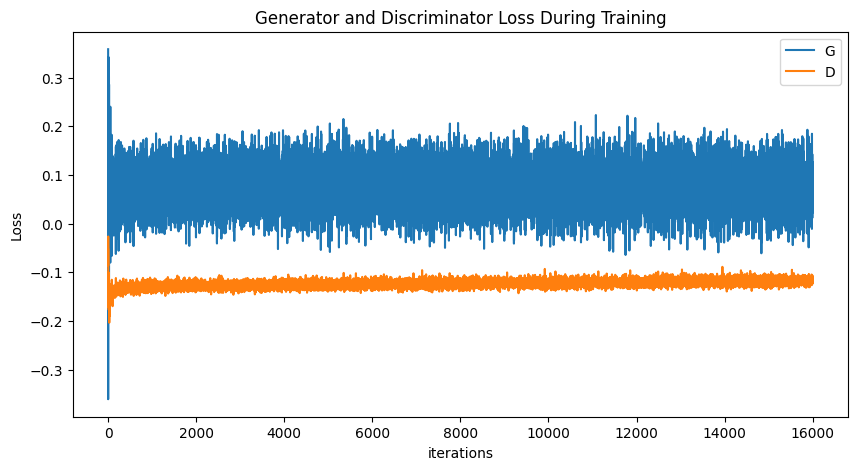

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [175]:
# Calculate FID
import torch
import torchvision
import torchvision.transforms as transforms
from pytorch_fid import fid_score
from PIL import Image
import os

# Resized original dataset path after 64x64 pixel adjustment
resized_folder_path = './resized_flowers102/'
# Generated image folder
generated_images_folder = './GENIMG/'
# Use Inception V3 model to calculate FID
inception_model = torchvision.models.inception_v3(pretrained=True)
fid_value = fid_score.calculate_fid_given_paths([resized_folder_path, generated_images_folder], batch_size=batch_size, device=device, dims=2048, num_workers=8)
print('FID value:', fid_value)

/home/m314834001/Lab7/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/m314834001/Lab7/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID value: 58.51440599587323


In [25]:
len(img_list)

33

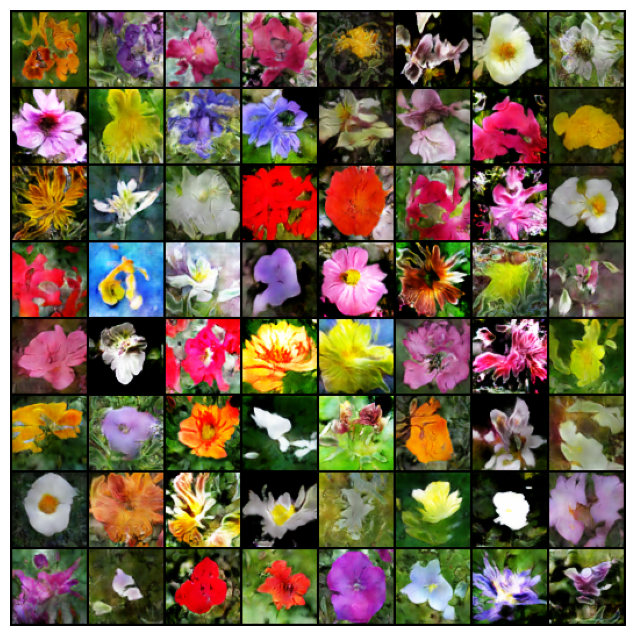

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# plt.rcParams['animation.embed_limit'] = 50

# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in (img_list)]
# ani = animation.ArtistAnimation(fig, ims, interval=166, repeat_delay=1000, blit=False)

# from IPython.display import HTML
# HTML(ani.to_jshtml())

In [148]:
import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# 假設這些參數已定義
grid_size = 8   # 網格大小 (8x8)
device = 'cuda'  # 裝置

def visualize_latent_grid(netG, nz, grid_size, device):
    """
    在潛在空間的兩個軸上進行插值，並生成圖片網格。
    """
    
    # 1. 創建一個基礎向量 (通常是零向量，或使用一個固定的隨機向量)
    # 我們將使用一個固定的隨機向量作為插值起點
    base_noise = torch.randn(1, nz, 1, 1, device=device)
    print(
        f"Shape: {base_noise.shape}, "
        f"Max Value: {base_noise.max().item():.4f}, "
        f"Min Value: {base_noise.min().item():.4f}, "
        f"Min Absolute Value: {base_noise.abs().min().item():.4f}"
    )
    
    interp_range = torch.linspace(-2, 2, grid_size)
    
    # 儲存所有生成的圖片
    grid_images = []
    
    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                # 複製基礎向量
                z = base_noise.clone()
                
                # 沿著軸改變數值
                z[0, 0    :8      , 0, 0] = interp_range[j]
                z[0, nz//2:nz//2+8, 0, 0] = interp_range[i]
                
                # 生成圖片
                fake_image = netG(z)
                grid_images.append(fake_image)

    # 5. 製作網格圖片
    grid_tensor = torch.cat(grid_images, dim=0) # 堆疊所有圖片
    grid_image = vutils.make_grid(grid_tensor, padding=2, normalize=True, nrow=grid_size)
    
    # 6. 顯示結果
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.title(f"Latent Space Interpolation")
    plt.imshow(np.transpose(grid_image.cpu().numpy(), (1, 2, 0)))
    plt.show()

Shape: torch.Size([1, 128, 1, 1]), Max Value: 2.3432, Min Value: -2.0636, Min Absolute Value: 0.0170


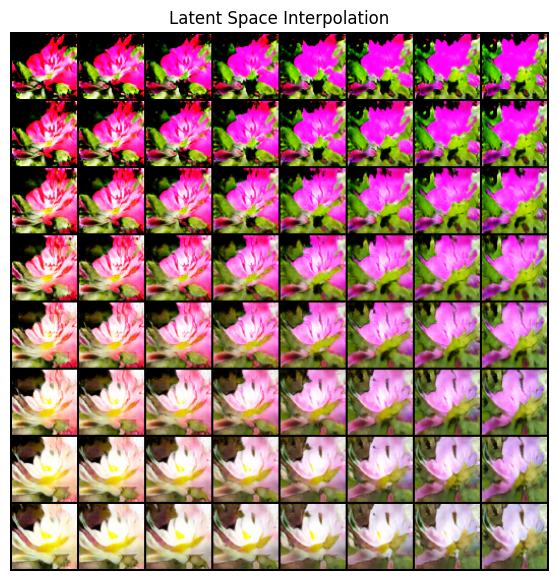

In [162]:
visualize_latent_grid(netG, nz, grid_size=8, device=device)

## Predict Result

In [28]:
import pandas as pd

df_submission = pd.DataFrame({
    'id': [1], 
    'fid_score': [fid_value]
})

output_csv_path = 'result.csv'
df_submission.to_csv(output_csv_path, index=False)